# **Maestría en Inteligencia Artificial Aplicada**
## Proyecto Integrador (Gpo 26)
> ### Tecnológico de Monterrey
>### Avance 6 - **Conclusiones Clave**


## -

## **Automatización del Registro de Materiales Médicos mediante Visión Computacional**

### *EQUIPO* 26


* ### Luis Fernando Rojas Marta - A00757351
* ### Jose Eduardo Carreon - A01372413


Para este avance 6 de **Conclusiones finales** se presentan los resultados de dos evaluaciones enfocadas en medir el desempeño del sistema de identificacion automatica de etiquetas mediante el uso de vision computacional.

La primera Etapa analiza como influye el numero de etiquetas presentes en una misma imagen en la calidad del reconocimiento. La segunda etapa se enfoca en evaluar como la distancia y los niveles de iluminacion afectan la confianza tanto en la deteccion de etiquetas (YOLO) como en la lectura de texto (OCR).

Estas dos etapas permiten determinar con mayor precision las condiciones mas optimas para el uso del sistema asi como sus limites, esto con el fin de poder tomar decisiones informadas para su implementacion o ajustes en fases posteriores.

### **Carga e Instalacion de Librerias y Modelos:**
Ejecutar una sola vez

In [ ]:
#Instalacion de Librerias de YOLO y EasyOCR
!pip install ultralytics
!pip install easyocr

In [2]:
#Montaje de la Unidad de Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Importacion de las Librerias
from ultralytics import YOLO
import cv2
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import time
from PIL import Image
import easyocr
from datetime import datetime
import seaborn as sns


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Funciones para el procesado de imagenes:**
-Ejectuar una sola vez.


In [4]:
####################
'''
FUNCIONES y MODELO:
'''
####################

#### Carga del modelo
model = YOLO("/content/drive/MyDrive/Proyecto_Integrador/YOLOv8_resultados50EPOCH/train/weights/best.pt") # Direccion Fer


#### ##### RUTINA PRINCIPAL ######
def procesar_imagen_con_etiquetas(ruta_imagen, etiquetas=["REF", "LOT", "FABRICACION", "CADUCIDAD"], confianza_threshold=0.60):
    #IMAGEN: Cargar la imagen
    image = cv2.imread(ruta_imagen)

    #YOLO: Inferencia
    results = model(image)[0]

    #OCR: Inicializar lector OCR
    reader = easyocr.Reader(['en'])  #Agregar  'es' si se requiere para las Tags

    resultados = []

    for i in range(len(results.boxes)):
        conf = results.boxes.conf[i].item()
        if conf < confianza_threshold:         #Se revisa que la confianza de la inferencia sea mayor al Threshold (default= 60%)
            print(f"[Descartado] Corte #{i+1} - Confianza: {conf:.2f}")
            continue

        #RECORTE: Crop a imagen
        x1, y1, x2, y2 = map(int, results.boxes.xyxy[i].tolist())
        crop = image[y1:y2, x1:x2]

        #OCR para este crop
        ocr_result = reader.readtext(crop)
        textos = [res[1] for res in ocr_result]
        results_df = pd.DataFrame(textos, columns=["Text"])

        #EXTRACCION FECHAS si es necesario
        incluir_fab = "FABRICACION" in etiquetas
        incluir_cad = "CADUCIDAD" in etiquetas
        fab_fecha, cad_fecha = None, None
        if incluir_fab or incluir_cad:
            fab_fecha, cad_fecha = extraer_fechas(results_df)

        #EXTRACCION TAGS OCR reales
        etiquetas_ocr = [et for et in etiquetas if et not in ["FABRICACION", "CADUCIDAD"]]
        valores = extraer_valores_por_tag(results_df, etiquetas_ocr)

        if incluir_fab:
            valores["FABRICACION"] = fab_fecha
        if incluir_cad:
            valores["CADUCIDAD"] = cad_fecha

        #CONSTRUCCION entrada del resultado
        resultado = {
            "corte": len(resultados) + 1,
            "valores": valores,
            "crop": crop,
            "confianza": conf
        }
        resultados.append(resultado)
        print(f"[Agregado] Corte #{resultado['corte']} - Confianza: {conf:.2f}")

    return resultados



###### Funcion para extraer fechas en formato AAAA-MM-DD
def extraer_fechas(results_df):
    fecha_patron = r"\b\d{4}-\d{2}-\d{2}\b"
    fechas = []

    for idx, texto in results_df["Text"].items():
        if pd.isna(texto):
            continue

        #Buscar fechas en el texto
        fechas_encontradas = re.findall(fecha_patron, texto)
        fechas.extend(fechas_encontradas)

    #Eliminar duplicados y ordenar por fecha
    fechas = sorted(list(set(fechas)))

    #Determinar FAB y CAD
    if len(fechas) == 1:
        return "NA", fechas[0]  # Solo una fecha → es CADUCIDAD
    elif len(fechas) >= 2:
        return fechas[0], fechas[1]  # FAB, CAD
    else:
        return "NA", "NA"


###### Funcion para buscar valores por etiquetas
def extraer_valores_por_tag(results_df, tags):
    valores = {tag: "NA" for tag in tags}

    for tag in tags:
        for idx, texto in results_df["Text"].items():
            if pd.isna(texto):
                continue

            #Se limpia el texto para comparacion
            clean_texto = texto.upper().replace("[", "").replace("]", "")

            #Caso 1: Si es exactamente igual (etiqueta sola), tomamos siguiente entrada
            if clean_texto.strip() == tag:
                if idx + 1 in results_df.index:
                    texto_extraido = results_df.loc[idx + 1, "Text"]
                    valores[tag] = limpiar_valor_por_tag(tag, texto_extraido)
                break

            #Caso 2:Si la etiqueta viene combinada con el valor
            elif tag in clean_texto:
                match = re.search(rf"{tag}\s*[:\-]?\s*([A-Z0-9\(\)]+)", clean_texto)
                if match:
                    valores[tag] = limpiar_valor_por_tag(tag, match.group(1))
                    break
                partes = clean_texto.split()
                if len(partes) > 1 and tag in partes[0]:
                    valores[tag] = limpiar_valor_por_tag(tag, partes[1])
                    break

    return valores

####### Limpieza por TAG

def limpiar_valor_por_tag(tag, valor):
    if not isinstance(valor, str):
        return valor

    val = valor.strip().upper()

    if tag == "REF" and val.startswith("(240"):
        val = val[5:]  #Limpieza del "(240" y el siguiente caracter

    elif tag == "LOT" and val.startswith("(10"):
        val = val[4:]  #Limpieza del "(10" y el siguiente caracter

    return val


####### Consrtuccion de fila en el Dataframe
def construir_fila_dataframe(ruta_imagen, valores_dict):
    fecha_actual = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    base_fila = {
        "imagen": os.path.basename(ruta_imagen),
        "fecha_procesado": fecha_actual,
        "REF": valores_dict.get("REF", "NA"),
        "LOT": valores_dict.get("LOT", "NA"),
        "FABRICACION": valores_dict.get("FABRICACION", "NA"),
        "CADUCIDAD": valores_dict.get("CADUCIDAD", "NA")
    }

    #Agregar si hay etiquetas adicionales
    etiquetas_extra = [k for k in valores_dict if k not in base_fila]
    for extra in etiquetas_extra:
        base_fila[extra] = valores_dict[extra]

    return pd.DataFrame([base_fila])

###### Guardado en un CSV
def guardar_en_csv(df_fila, nombre_csv="/content/drive/MyDrive/Proyecto_Integrador/datos_etiquetas.csv"):
    if os.path.exists(nombre_csv):
        df_fila.to_csv(nombre_csv, mode='a', header=False, index=False)
    else:
        df_fila.to_csv(nombre_csv, mode='w', header=True, index=False)


##### Mostrado de Recortss
def mostrar_recortes(resultados):
    for res in resultados:
        plt.imshow(cv2.cvtColor(res["crop"], cv2.COLOR_BGR2RGB))
        plt.title(f"Corte # {res['corte']} - Confianza: {res['confianza']:.2f}: ")
        plt.axis('off')
        plt.show()

#########################################
#Funcion Exclusiva para este avance 6 :
def analizar_imagenes_por_folder(ruta_folder):
    resultados = []

    #Checar foldre por solo 3 imagenes
    imagenes = [f for f in os.listdir(ruta_folder) if f.lower().endswith(('.jpg', '.JPG', '.png'))]
    imagenes = sorted(imagenes)[:3]  #Tomar solo las primeras 3 para este analisis

    for img_name in imagenes:
        ruta_img = os.path.join(ruta_folder, img_name)

        #Procesar cada imagen:
        resultados_ocr = procesar_imagen_con_etiquetas(ruta_img, etiquetas)

        for idx, resultado in enumerate(resultados_ocr):
            fila = {"IMG": img_name, "CORTE": idx + 1, "CONF_RECORTE": resultado["confianza"] }

            valores = resultado["valores"]
            for tag in etiquetas:
                fila[f"{tag}_VALOR"] = valores.get(tag, "NA")

            resultados.append(fila)

            #Mostrar el recorte de imagen:
            crop = resultado["crop"]
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.title(f"{img_name}: corte #{idx + 1} -> Conf.: {resultado['confianza']:.3f}")
            plt.axis('off')
            plt.show()

    df_resultados = pd.DataFrame(resultados)
    return df_resultados



## **ETAPA 1: Evaluar desempeño según número de etiquetas**

Propósito:
> Validar si la cantidad de etiquetas por imagen afecta la precision de los valoes extraidos del OCR y la confianza de inferencia de YOLO.

1.   Comparar la calidad del reconocimiento OCR y las confianzas al procesar imágenes que contienen:

* 1 sola etiqueta.
* 2 etiquetas
* 3 etiquetas

***CONCLUSION AL FINAL***

## **Una imagen con una etiqueta:**
Etiqueta Individual

In [5]:
#Etiquetas a evaluar
etiquetas = ["REF", "LOT", "FABRICACION", "CADUCIDAD"]



0: 640x640 1 etiqueta, 277.6ms
Speed: 6.1ms preprocess, 277.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.91


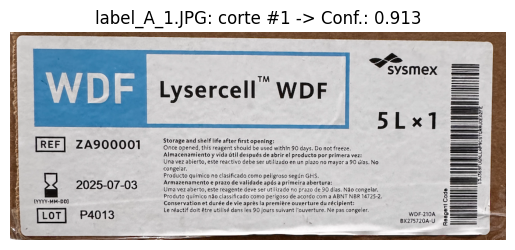


0: 640x640 1 etiqueta, 403.3ms
Speed: 10.9ms preprocess, 403.3ms inference, 16.8ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.94


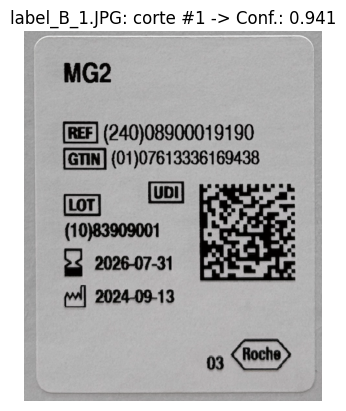


0: 640x640 1 etiqueta, 285.2ms
Speed: 11.6ms preprocess, 285.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.93


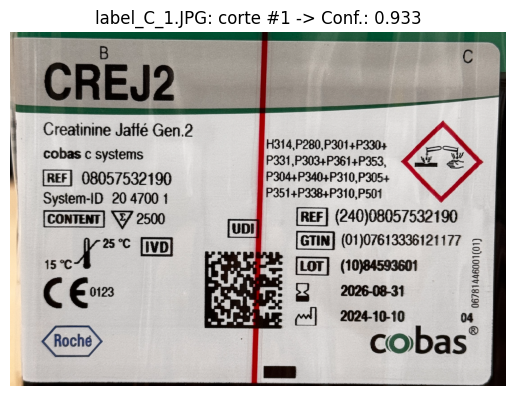

IMG  CORTE  CONF_RECORTE    REF_VALOR LOT_VALOR  \
0  label_A_1.JPG      1      0.912769     ZA900001     P4013   
1  label_B_1.JPG      1      0.940813  08900019190  83909001   
2  label_C_1.JPG      1      0.932547  08057532190  84593601   

  FABRICACION_VALOR CADUCIDAD_VALOR  
0                NA      2025-07-03  
1        2024-09-13      2026-07-31  
2        2024-10-10      2026-08-31

In [12]:
#Analisis del primer folder:
df_uno = analizar_imagenes_por_folder("/content/drive/MyDrive/Proyecto_Integrador/Labels_Avance6/Uno")
display(df_uno)

## **Una imagen con dos etiquetas:**
Etiquetas dobles


0: 480x640 2 etiquetas, 289.1ms
Speed: 7.2ms preprocess, 289.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.68
[Descartado] Corte #2 - Confianza: 0.52


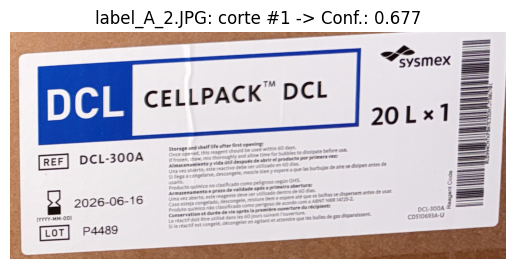


0: 544x640 2 etiquetas, 235.3ms
Speed: 9.1ms preprocess, 235.3ms inference, 5.5ms postprocess per image at shape (1, 3, 544, 640)


[Agregado] Corte #1 - Confianza: 0.96
[Agregado] Corte #2 - Confianza: 0.95


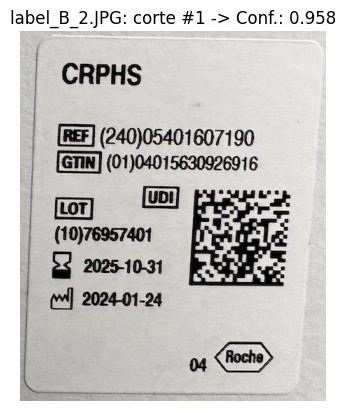

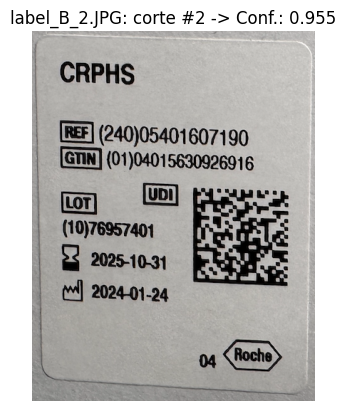


0: 512x640 2 etiquetas, 228.5ms
Speed: 8.1ms preprocess, 228.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


[Agregado] Corte #1 - Confianza: 0.96
[Agregado] Corte #2 - Confianza: 0.94


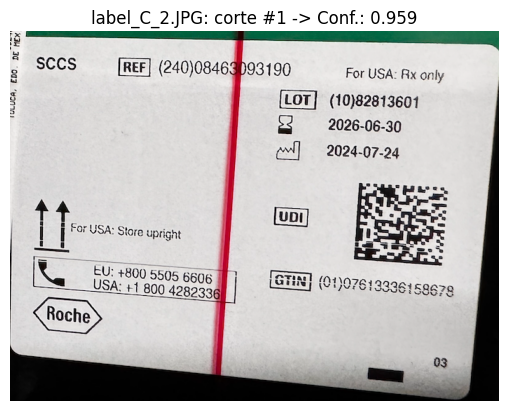

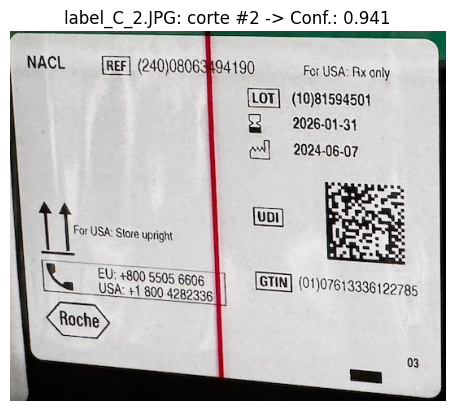

IMG  CORTE  CONF_RECORTE          REF_VALOR LOT_VALOR  \
0  label_A_2.JPG      1      0.677263          TF FROZEN     P4489   
1  label_B_2.JPG      1      0.957630                 NA  76957401   
2  label_B_2.JPG      2      0.954660  [(240105401607190  76957401   
3  label_C_2.JPG      1      0.959483       08462 093190        NA   
4  label_C_2.JPG      2      0.941006        08063494190        NA   

  FABRICACION_VALOR CADUCIDAD_VALOR  
0                NA      2026-06-16  
1        2024-01-24      2025-10-31  
2        2024-01-24      2025-10-31  
3        2024-07-24      2026-06-30  
4        2024-06-07      2026-01-31

In [7]:
#Analisis del Segundo folder:
df_dos = analizar_imagenes_por_folder("/content/drive/MyDrive/Proyecto_Integrador/Labels_Avance6/Dos")
display(df_dos)


## **Una imagen con tres etiquetas:**
Etiquetas triples


0: 480x640 3 etiquetas, 186.0ms
Speed: 5.2ms preprocess, 186.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.86
[Agregado] Corte #2 - Confianza: 0.85
[Agregado] Corte #3 - Confianza: 0.84


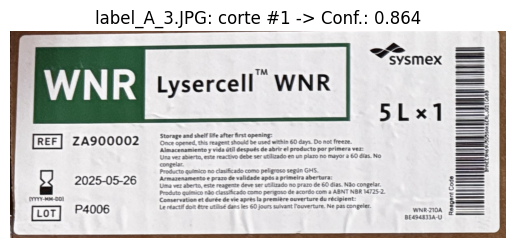

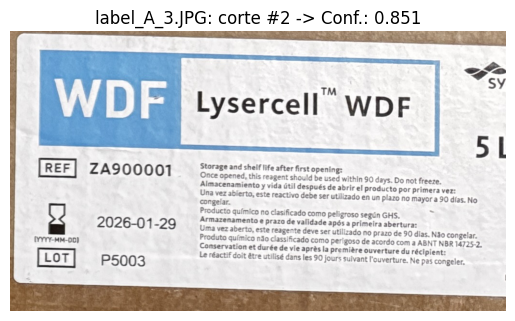

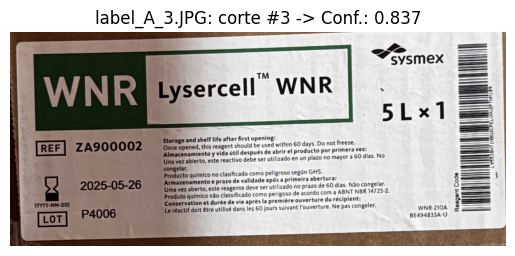


0: 480x640 3 etiquetas, 194.4ms
Speed: 8.2ms preprocess, 194.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.94
[Agregado] Corte #2 - Confianza: 0.90
[Agregado] Corte #3 - Confianza: 0.89


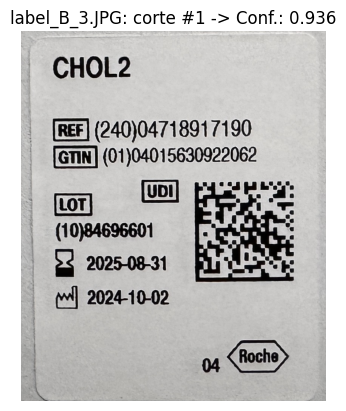

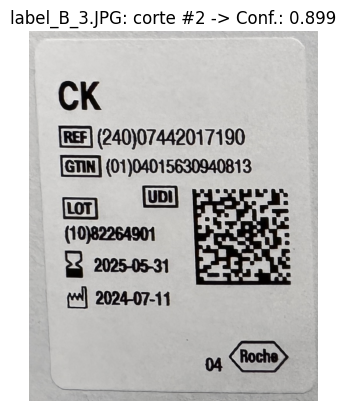

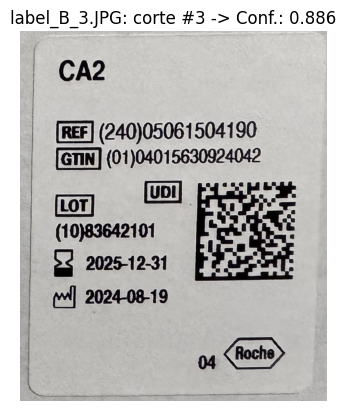


0: 480x640 3 etiquetas, 225.5ms
Speed: 14.2ms preprocess, 225.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.94
[Agregado] Corte #2 - Confianza: 0.93
[Agregado] Corte #3 - Confianza: 0.91


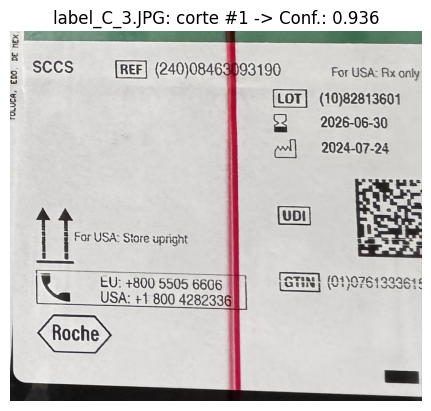

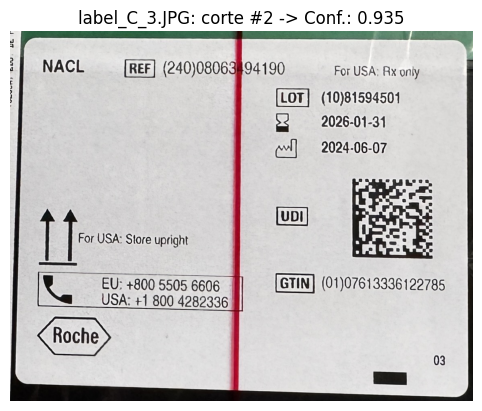

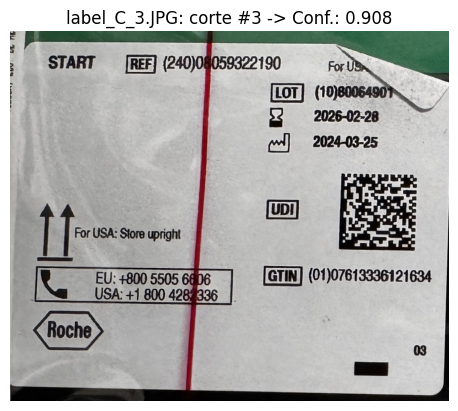

IMG  CORTE  CONF_RECORTE     REF_VALOR    LOT_VALOR  \
0  label_A_3.JPG      1      0.863557      ZA900002  BE4948334-U   
1  label_A_3.JPG      2      0.850507      ZA9OOOO1        P5003   
2  label_A_3.JPG      3      0.836726      ZA90OOO2     CONGELER   
3  label_B_3.JPG      1      0.936170   04718917190     84696601   
4  label_B_3.JPG      2      0.899017            NA           NA   
5  label_B_3.JPG      3      0.886047   05061504190     83642101   
6  label_C_3.JPG      1      0.936328  08463 193190     82813601   
7  label_C_3.JPG      2      0.934571   08063194190     81594501   
8  label_C_3.JPG      3      0.908366             I           NA   

  FABRICACION_VALOR CADUCIDAD_VALOR  
0                NA      2025-05-26  
1                NA      2026-01-29  
2                NA      2025-05-26  
3        2024-10-02      2025-08-31  
4        2024-07-11      2025-05-31  
5        2024-08-19      2025-12-31  
6        2024-07-24      2026-06-30  
7        2024-06-07      2026-01-31  
8        2024-03-25      2026-02-20

In [8]:
#Analisis del tercer folder:
df_tres = analizar_imagenes_por_folder("/content/drive/MyDrive/Proyecto_Integrador/Labels_Avance6/Tres")
display(df_tres)

In [9]:
#ANALISIS DE CANTIDAD DE ETIQUETAS y TAGS encontradas para comparativa:
#ANEXACION de Columna de grupo a cada DF
df_uno["NUM_ETIQUETAS"] = 1
df_dos["NUM_ETIQUETAS"] = 2
df_tres["NUM_ETIQUETAS"] = 3

#CONCATENAR de los 3 DFs
df_total = pd.concat([df_uno, df_dos, df_tres], ignore_index=True)

#AGRUPAR por numero de etiquetas - CALCULO promedio confianza de YOLO
resumen = df_total.groupby("NUM_ETIQUETAS").agg({
    "CONF_RECORTE": "mean"
}).rename(columns={"CONF_RECORTE": "PROMEDIO_CONF_YOLO"})

#CALCULO de cantidad valores OCR detectados (excluyendo "NA") por tipo de etiqueta
for tag in ["REF", "LOT", "FABRICACION", "CADUCIDAD"]:
    col_tag = f"{tag}_VALOR"
    col_out = f"{tag}_DETECTADAS"
    conteo = df_total[df_total[col_tag] != "NA"].groupby("NUM_ETIQUETAS").size()
    resumen[col_out] = conteo

#Mostrado de dataframe:
display(resumen)

PROMEDIO_CONF_YOLO  REF_DETECTADAS  LOT_DETECTADAS  \
NUM_ETIQUETAS                                                       
1                        0.928710               3               3   
2                        0.898008               4               3   
3                        0.894588               8               7   

               FABRICACION_DETECTADAS  CADUCIDAD_DETECTADAS  
NUM_ETIQUETAS                                                
1                                   2                     3  
2                                   4                     5  
3                                   6                     9

#### **Conclusion de la Etapa 1**: Evaluación por cantidad de etiquetas por imagen

El analisis de la precision en base al numero de etiquetas en las imagenes demuestra que el desempeño del sistema se ve afectado conforme aumenta la cantidad de informacion/numero de etiquetas.

1. **En las imagenes con una sola etiqueta**: el modelo si logro identificar con precision los valores de referencia, lote y fechas de caducidad disponibles, mostrando una confianza promedio de YOLO de 92.9%, y sin errores de lectura. Esto indica que el sistema es altamente confiable cuando se enfoca en una sola etiqueta por imagen.
>
2. **Para las imagenes con dos etiquetas**: se tuvieron ligeras inconsistencias en los valores, principalmente en la detección del valor de lote `LOT` ya que fue omitido en al menos una de las imagenes analizadas. Aun asi los valores que si se detectaron mostraron ser correctos, lo que sugiere que el modelo aun funciona bien, aunque ya se empieza a comprometer la capacidad al cubrir mas etiquetas.
>

3. **En las imagenes con tres etiquetas**: aunque el modelo logro extraer la mayoria de los campos disponibles, si se presento una caída leve en la confianza y algunas etiquetas (especialmente `REF` y `LOT`) fueron omitidas. Esta caida se atribuye al aumento de la distancia de la captura y a que se disminuye la resolucion disponible por etiqeuta. Asi como tambien a la presencia de etiquetas a distintos angulos y reflejos causados por las envolturas plásticas. Estos factores dificultaron tanto la deteccion de etiquetas como la lectura de los textos.

**En conclusión**: se recomienda priorizar el uso de imagenes con una o maximo dos etiquetas por captura de imagen, y mantener un control del aspecto de la imagen (sin angulos ni reflejos) para maximizar la calidad del desempeño del sistema. Para escenarios mas complejos con mas etiquetas, seria conveniente explorar otras tecnicas de normalizacion de perspectiva, aumentos de contrastes o el uso de una camara fija con una mejor iluminación uniforme.

## **ETAPA 2: Heatmaps separados de confianza (OCR y YOLO)**

Objetivo:
> **Heatmap 1:** Mostrar como afecta la distancia/iluminacion a la confianza del OCR.

> **Heatmap 2:** Mostrar como  se afecta a la confianza del modelo de inferencia de YOLOv8.


Analisis de Imagenes para Comparativa de Lux y Dist.

***CONCLUSION AL FINAL***

In [10]:
#CARGA de datos
ruta_base = "/content/drive/MyDrive/Proyecto_Integrador/Analisis_Precision_r1/"
ruta_csv = os.path.join(ruta_base, "tabla_datos_r2.csv")
df_esperados = pd.read_csv(ruta_csv)
df_esperados.columns = [col.strip().upper().replace(" ", "_") for col in df_esperados.columns]

#INICIALIZACION lista de resultados
resultados_confianza = []

#CICLO for para cada imagen
for _, row in df_esperados.iterrows():
    nombre_img = row["NAME"]
    ruta_imagen = os.path.join(ruta_base, nombre_img)

    #INFERENCIA con RUTINA general
    resultados_ocr = procesar_imagen_con_etiquetas(ruta_imagen, etiquetas=["REF", "LOT", "FABRICACION", "CADUCIDAD"])

    #GUARDADO de confianzas por recorte valido (Arriba de 60%)
    confs_yolo = []
    confs_ocr = []

    for resultado in resultados_ocr:
        conf_yolo = resultado["confianza"]
        confs_yolo.append(conf_yolo)

        crop_texts = resultado.get("valores", {})
        for val in crop_texts.values():
            if isinstance(val, str) and val.strip() != "NA":
                confs_ocr.append(conf_yolo)  #Se usa confianza del corte como proxy OCR

    #CALCULO de promedios por cada imagen
    promedio_yolo = np.mean(confs_yolo) if confs_yolo else 0
    promedio_ocr = np.mean(confs_ocr) if confs_ocr else 0

    resultados_confianza.append({
        "NAME": nombre_img,
        "LUX": row["LUX"],
        "DISTANCIA_CM": row["DISTANCIA_(CM)"],
        "CONF_YOLO": promedio_yolo,
        "CONF_OCR": promedio_ocr
    })

#CREACION del Dataframe final
df_confianza = pd.DataFrame(resultados_confianza)

#MAPEO de LUX a etiquetas
def categorizar_lux(lux):
    if lux <= 200:
        return "<200 Lux (Baja)"
    elif lux <= 300:
        return "250 Lux (Media)"
    else:
        return ">300 (Alta)"

df_confianza["LUX_RANGO"] = df_confianza["LUX"].apply(categorizar_lux)
df_confianza["DIST_ETIQUETA"] = df_confianza["DISTANCIA_CM"].astype(str) + " cm"


0: 640x480 2 etiquetas, 240.5ms
Speed: 5.8ms preprocess, 240.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.88
[Agregado] Corte #2 - Confianza: 0.78

0: 640x480 2 etiquetas, 264.5ms
Speed: 4.9ms preprocess, 264.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.72
[Descartado] Corte #2 - Confianza: 0.43

0: 640x576 2 etiquetas, 352.9ms
Speed: 7.9ms preprocess, 352.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


[Agregado] Corte #1 - Confianza: 0.89
[Descartado] Corte #2 - Confianza: 0.60

0: 640x480 1 etiqueta, 209.9ms
Speed: 6.0ms preprocess, 209.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.92

0: 640x480 1 etiqueta, 198.6ms
Speed: 5.7ms preprocess, 198.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.85

0: 640x640 1 etiqueta, 443.9ms
Speed: 8.5ms preprocess, 443.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.91

0: 640x480 1 etiqueta, 222.1ms
Speed: 7.7ms preprocess, 222.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.92

0: 640x480 1 etiqueta, 205.1ms
Speed: 5.7ms preprocess, 205.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.88

0: 640x448 1 etiqueta, 221.5ms
Speed: 4.7ms preprocess, 221.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


[Agregado] Corte #1 - Confianza: 0.93

0: 640x480 1 etiqueta, 317.3ms
Speed: 7.3ms preprocess, 317.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.93

0: 640x480 1 etiqueta, 198.7ms
Speed: 8.3ms preprocess, 198.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.89

0: 640x544 1 etiqueta, 375.3ms
Speed: 9.6ms preprocess, 375.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[Agregado] Corte #1 - Confianza: 0.95

0: 640x480 1 etiqueta, 211.8ms
Speed: 6.3ms preprocess, 211.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.97

0: 640x480 1 etiqueta, 194.0ms
Speed: 7.5ms preprocess, 194.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.88

0: 480x640 1 etiqueta, 324.9ms
Speed: 7.0ms preprocess, 324.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.96

0: 640x480 1 etiqueta, 318.0ms
Speed: 9.7ms preprocess, 318.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.94

0: 640x480 1 etiqueta, 210.7ms
Speed: 6.6ms preprocess, 210.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.87

0: 480x640 1 etiqueta, 297.3ms
Speed: 7.7ms preprocess, 297.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.95

0: 640x480 1 etiqueta, 206.9ms
Speed: 8.0ms preprocess, 206.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.96

0: 640x480 1 etiqueta, 211.6ms
Speed: 32.1ms preprocess, 211.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.89

0: 640x640 1 etiqueta, 284.9ms
Speed: 6.4ms preprocess, 284.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.96

0: 640x480 2 etiquetas, 222.9ms
Speed: 7.9ms preprocess, 222.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.88
[Agregado] Corte #2 - Confianza: 0.64

0: 640x480 1 etiqueta, 246.1ms
Speed: 6.0ms preprocess, 246.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.82

0: 640x576 2 etiquetas, 380.2ms
Speed: 9.0ms preprocess, 380.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


[Agregado] Corte #1 - Confianza: 0.89
[Descartado] Corte #2 - Confianza: 0.60

0: 640x480 1 etiqueta, 204.0ms
Speed: 6.8ms preprocess, 204.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.89

0: 640x480 1 etiqueta, 217.3ms
Speed: 5.6ms preprocess, 217.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.84

0: 640x640 1 etiqueta, 542.6ms
Speed: 21.9ms preprocess, 542.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.91

0: 640x480 1 etiqueta, 261.4ms
Speed: 7.9ms preprocess, 261.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.95

0: 640x480 1 etiqueta, 237.4ms
Speed: 6.2ms preprocess, 237.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.94

0: 640x480 1 etiqueta, 201.7ms
Speed: 6.1ms preprocess, 201.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.88

0: 640x480 1 etiqueta, 196.7ms
Speed: 5.8ms preprocess, 196.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.90

0: 640x480 1 etiqueta, 210.4ms
Speed: 7.8ms preprocess, 210.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.89

0: 640x448 1 etiqueta, 224.0ms
Speed: 5.7ms preprocess, 224.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[Agregado] Corte #1 - Confianza: 0.93

0: 640x480 1 etiqueta, 343.6ms
Speed: 17.1ms preprocess, 343.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.92

0: 640x480 1 etiqueta, 222.5ms
Speed: 7.9ms preprocess, 222.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.89

0: 480x640 1 etiqueta, 385.9ms
Speed: 6.8ms preprocess, 385.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.95

0: 640x480 1 etiqueta, 297.8ms
Speed: 6.9ms preprocess, 297.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.93

0: 640x480 1 etiqueta, 208.3ms
Speed: 6.4ms preprocess, 208.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.88

0: 480x640 1 etiqueta, 209.1ms
Speed: 6.8ms preprocess, 209.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.96

0: 640x480 1 etiqueta, 213.4ms
Speed: 4.7ms preprocess, 213.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.92

0: 640x480 1 etiqueta, 205.5ms
Speed: 8.0ms preprocess, 205.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.92

0: 640x640 1 etiqueta, 288.6ms
Speed: 8.3ms preprocess, 288.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.96

0: 640x480 1 etiqueta, 225.2ms
Speed: 7.9ms preprocess, 225.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.86

0: 640x480 (no detections), 243.6ms
Speed: 5.9ms preprocess, 243.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)



0: 640x512 1 etiqueta, 271.4ms
Speed: 7.1ms preprocess, 271.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[Agregado] Corte #1 - Confianza: 0.93

0: 640x480 1 etiqueta, 223.8ms
Speed: 49.4ms preprocess, 223.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.88

0: 640x480 1 etiqueta, 215.0ms
Speed: 7.7ms preprocess, 215.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.85

0: 544x640 1 etiqueta, 247.5ms
Speed: 6.1ms preprocess, 247.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


[Agregado] Corte #1 - Confianza: 0.92

0: 640x480 1 etiqueta, 336.5ms
Speed: 8.8ms preprocess, 336.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.91

0: 640x480 1 etiqueta, 310.0ms
Speed: 11.7ms preprocess, 310.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.93

0: 640x640 1 etiqueta, 292.6ms
Speed: 7.0ms preprocess, 292.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.93

0: 640x480 1 etiqueta, 253.2ms
Speed: 6.4ms preprocess, 253.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.94

0: 640x480 1 etiqueta, 206.7ms
Speed: 9.4ms preprocess, 206.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.93

0: 640x352 1 etiqueta, 175.3ms
Speed: 4.7ms preprocess, 175.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[Agregado] Corte #1 - Confianza: 0.96

0: 640x480 1 etiqueta, 301.4ms
Speed: 10.0ms preprocess, 301.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.96

0: 640x480 1 etiqueta, 203.1ms
Speed: 9.6ms preprocess, 203.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.84

0: 640x640 1 etiqueta, 263.4ms
Speed: 6.4ms preprocess, 263.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[Agregado] Corte #1 - Confianza: 0.95

0: 640x480 1 etiqueta, 214.8ms
Speed: 6.5ms preprocess, 214.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.96

0: 640x480 1 etiqueta, 209.7ms
Speed: 6.3ms preprocess, 209.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.91

0: 480x640 1 etiqueta, 222.0ms
Speed: 6.4ms preprocess, 222.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.97

0: 640x480 1 etiqueta, 261.3ms
Speed: 8.1ms preprocess, 261.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.95

0: 640x480 1 etiqueta, 322.2ms
Speed: 7.4ms preprocess, 322.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


[Agregado] Corte #1 - Confianza: 0.89

0: 480x640 1 etiqueta, 1612.0ms
Speed: 60.3ms preprocess, 1612.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


[Agregado] Corte #1 - Confianza: 0.97


#### **Visualizacion de Heatmaps tras procesamiento:**

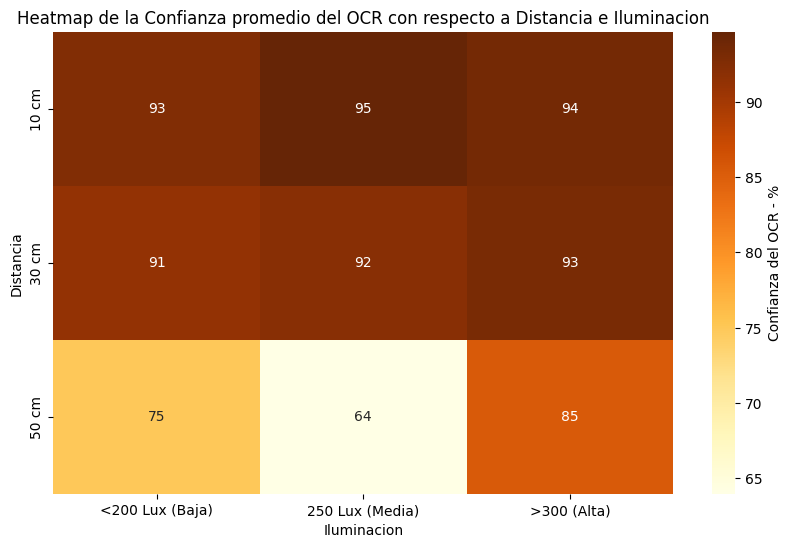

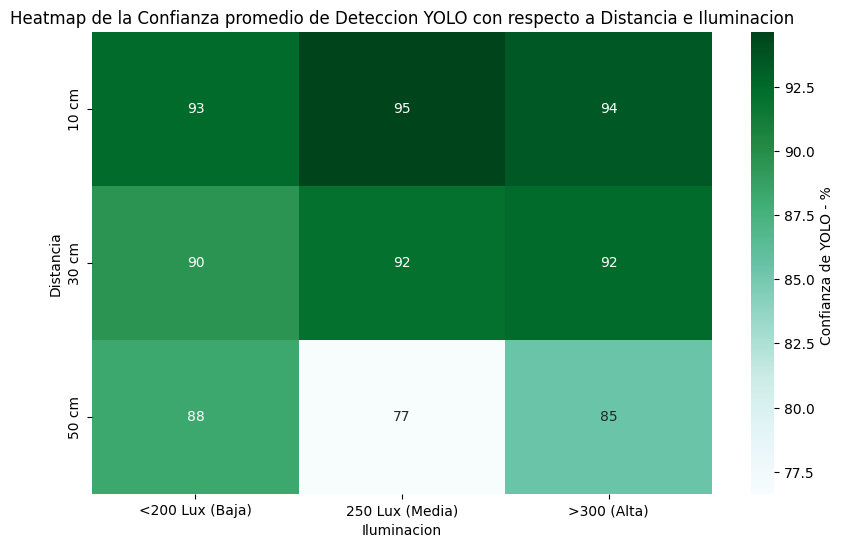

In [11]:
#LISTA de Lux para los heatmaps:
orden_lux = ["<200 Lux (Baja)", "250 Lux (Media)", ">300 (Alta)"]

#HEATMAP de Confianza de EasyOCR
pivot_ocr = df_confianza.pivot_table(values="CONF_OCR", index="DIST_ETIQUETA", columns="LUX_RANGO", aggfunc="mean").reindex(columns=orden_lux) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_ocr, annot=True,fmt=".00f", cmap="YlOrBr", cbar_kws={'label': 'Confianza del OCR - %'})
plt.title("Heatmap de la Confianza promedio del OCR con respecto a Distancia e Iluminacion")
plt.xlabel("Iluminacion")
plt.ylabel("Distancia")
plt.show()

#HEATMAP de confianza de inferencia de YOLO
pivot_yolo = df_confianza.pivot_table(values="CONF_YOLO", index="DIST_ETIQUETA", columns="LUX_RANGO", aggfunc="mean" ).reindex(columns=orden_lux) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_yolo, annot=True, fmt=".00f", cmap="BuGn", cbar_kws={'label': 'Confianza de YOLO - % '})
plt.title("Heatmap de la Confianza promedio de Deteccion YOLO con respecto a Distancia e Iluminacion")
plt.xlabel("Iluminacion")
plt.ylabel("Distancia")
plt.show()

#### **Conclusion de la Etapa 2**: Evaluacion de confianzas por distancia e iluminacion:

Los resultados muestran que el modelo de deteccion de YOLOv8 presenta una confianza promedio muy alta (>90%) en la mayoria de las combinaciones de distancia-iluminacion, por lo cual demuestra ser un componente robusto y confiable del sistema. En comparacion, la parte de reconocimiento del texto (OCR) mantiene niveles optimos de confianza (de entre 91%–95%) a distancias de 10 y 30 cms, pero experimenta una caida significativa a 50 cm, en especifico en condiciones de luz media (64%). Esto indica que mientras la deteccion de etiquetas es tecnicamente viable en un amplio rango de condiciones, la calidad del texto para la identificaion por OCR se ve afectada por la distancia.

En base a esto, podemos concluir que para futuras implementaciones se recomienda mantener las capturas de etiquetas dentro de un rango maximo de 30 cm o considerar tecnicas de enfoque, mejora de contraste, o preprocesamiento de imagen para extender la viabilidad del OCR a mayores distancias.